In [2]:
#pip install tensorflow transformers  tf-keras pandas matplotlib seaborn 
from transformers import pipeline
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

2024-04-19 14:33:59.981601: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 14:33:59.985738: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 14:34:00.035362: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 14:34:00.898587: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def load_classifier():
    classifier = pipeline("text-classification", 
                          model="j-hartmann/emotion-english-distilroberta-base", 
                          return_all_scores=False) 
    return classifier

In [3]:
classifier = load_classifier()

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
/home/ucloud/.local/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [6]:
def load_data(filepath):
    data_emotions_path = "../out/"+(filepath).split("/")[-1].split(".")[0] + "_with_emotion_scores.csv"
    data_in = pd.read_csv(filepath)
    data_emotions = pd.read_csv(filepath)
    data_emotions[["emotion_label", "emotion_score"]] = ""
    return data_in, data_emotions, data_emotions_path

In [7]:
data_in, data_emotions, data_emotions_path = load_data("../in/GoT-scripts/Game_of_Thrones_Script.csv")

In [8]:
def emotion_classifier(data_in, data_emotions, classifier, data_emotions_path):
    for sent in range(len(data_in["Sentence"])):
        sentence = data_in["Sentence"][sent]
        if type(sentence) == str:
            emotion_label = classifier(sentence)[0]["label"]
            emotion_score = classifier(sentence)[0]["score"]
            data_emotions.loc[sent, "emotion_label"] = emotion_label
            data_emotions.loc[sent, "emotion_score"] = emotion_score
        if sent%100 == 0:
            print(sent, data_in["Season"][sent], data_in["Episode"][sent])
    data_emotions.to_csv(data_emotions_path)
    return print("Emotion scores and labels for each sentence in the dataset have been saved to the outfolder")

In [ ]:
emotion_classifier(data_in, data_emotions, classifier, data_emotions_path)

In [3]:
def reshape_data(data_emotions_path):
    """
    The function takes path where the emotions data was saved, and reshapes it. The returned 
    dataframe has three columns, Season and emotion_label and count. For each season the 
    number of each of the seven emotion labels are counted, divided by the total number of 
    lines in the given season and multiplied by 100, resulting in relative requency of each 
    emotion label per 100 lines for each season. 
    """
    data_emotions = pd.read_csv(data_emotions_path, index_col=0, usecols=[0,2,7])
    Seasons = list(data_emotions.Season.unique())
    season_len = []
    for n in range(len(Seasons)):
        season = Seasons[n]
        season_len = season_len + [len(data_emotions.loc[data_emotions["Season"] == f"{season}"])]
    data_counts =  data_emotions.value_counts().reset_index().rename(columns={"index": "value", 0: "counts"})
    data_counts["Relative Frequency"] = ""
    for season, length in zip(Seasons, season_len):
        data_counts.loc[data_counts["Season"] == season, "Relative Frequency"] = data_counts.loc[data_counts["Season"] == season, "count"]/length * 100
    return data_counts

In [4]:
data_counts = reshape_data("../out/Game_of_Thrones_Script_with_emotion_scores.csv")

In [6]:
data_counts_nn = data_counts[data_counts["emotion_label"] != "neutral"]

In [11]:
def plot_emotions(data_counts, neutral):
    seasons =  ["Season 1", "Season 2", "Season 3", "Season 4", "Season 5", "Season 6", "Season 7", "Season 8"]
    if neutral == "keep_neutral":
        emotions = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
        #sns.set_theme(style = "whitegrid", palette="colorblind")
        g = sns.catplot(data_counts, 
                        x= "emotion_label", 
                        y = "Relative Frequency",
                        hue = "emotion_label",  
                        col = "Season", 
                        kind = "bar",
                        col_wrap = 4,
                        col_order = seasons,
                        fill = True, 
                        order = emotions
                        )
        g.set_xticklabels(labels=emotions, rotation=30) 
        plt.savefig("../out/emotions_per_season.png")

        g = sns.catplot(data_counts, 
                        x= "Season", 
                        y = "Relative Frequency",
                        hue = "emotion_label",  
                        col = "emotion_label", 
                        kind = "bar",
                        col_wrap = 4,
                        order = seasons,
                        fill = True, 
                        col_order = emotions
                        )
        g.set_xticklabels(labels=seasons, rotation=30) 
        plt.savefig("../out/season_per_emotion.png")
    elif neutral == "remove_neutral":
        data_counts_nn = data_counts[data_counts["emotion_label"] != "neutral"]
        emotions_nn = ["anger", "disgust", "fear", "joy", "sadness", "surprise"]
        g = sns.catplot(data_counts_nn, 
                        x= "emotion_label", 
                        y = "Relative Frequency",
                        hue = "emotion_label",  
                        col = "Season", 
                        kind = "bar",
                        col_wrap = 4,
                        col_order = seasons,
                        fill = True, 
                        order = emotions_nn)
        g.set_xticklabels(labels=emotions_nn, rotation=30) 
        plt.savefig("../out/emotions_per_season_rm_neutral.png")
        g = sns.catplot(data_counts_nn, 
                        x= "Season", 
                        y = "Relative Frequency",
                        hue = "emotion_label",  
                        col = "emotion_label", 
                        kind = "bar",
                        col_wrap = 3,
                        order = seasons,
                        fill = True, 
                        col_order = emotions_nn)
        g.set_xticklabels(labels=seasons, rotation=30) 
        plt.savefig("../out/season_per_emotion_rm_neutral.png")


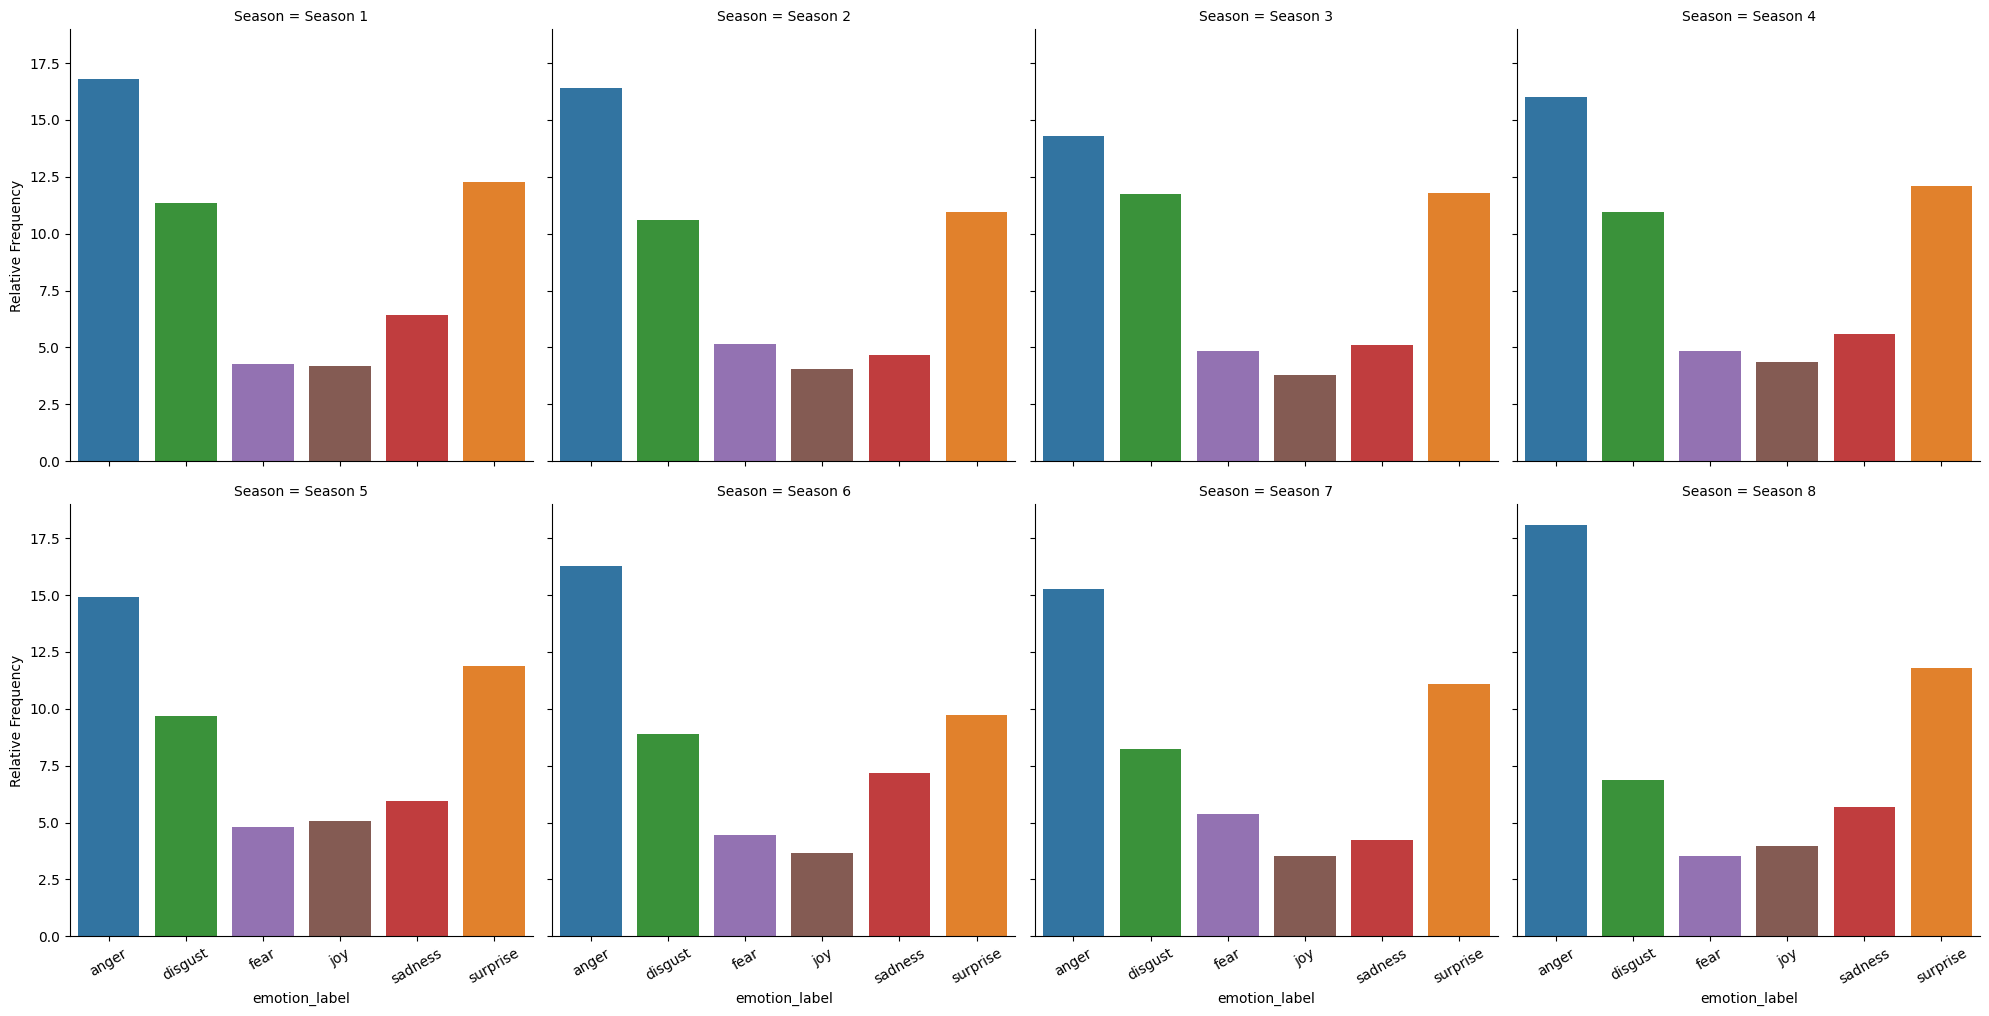

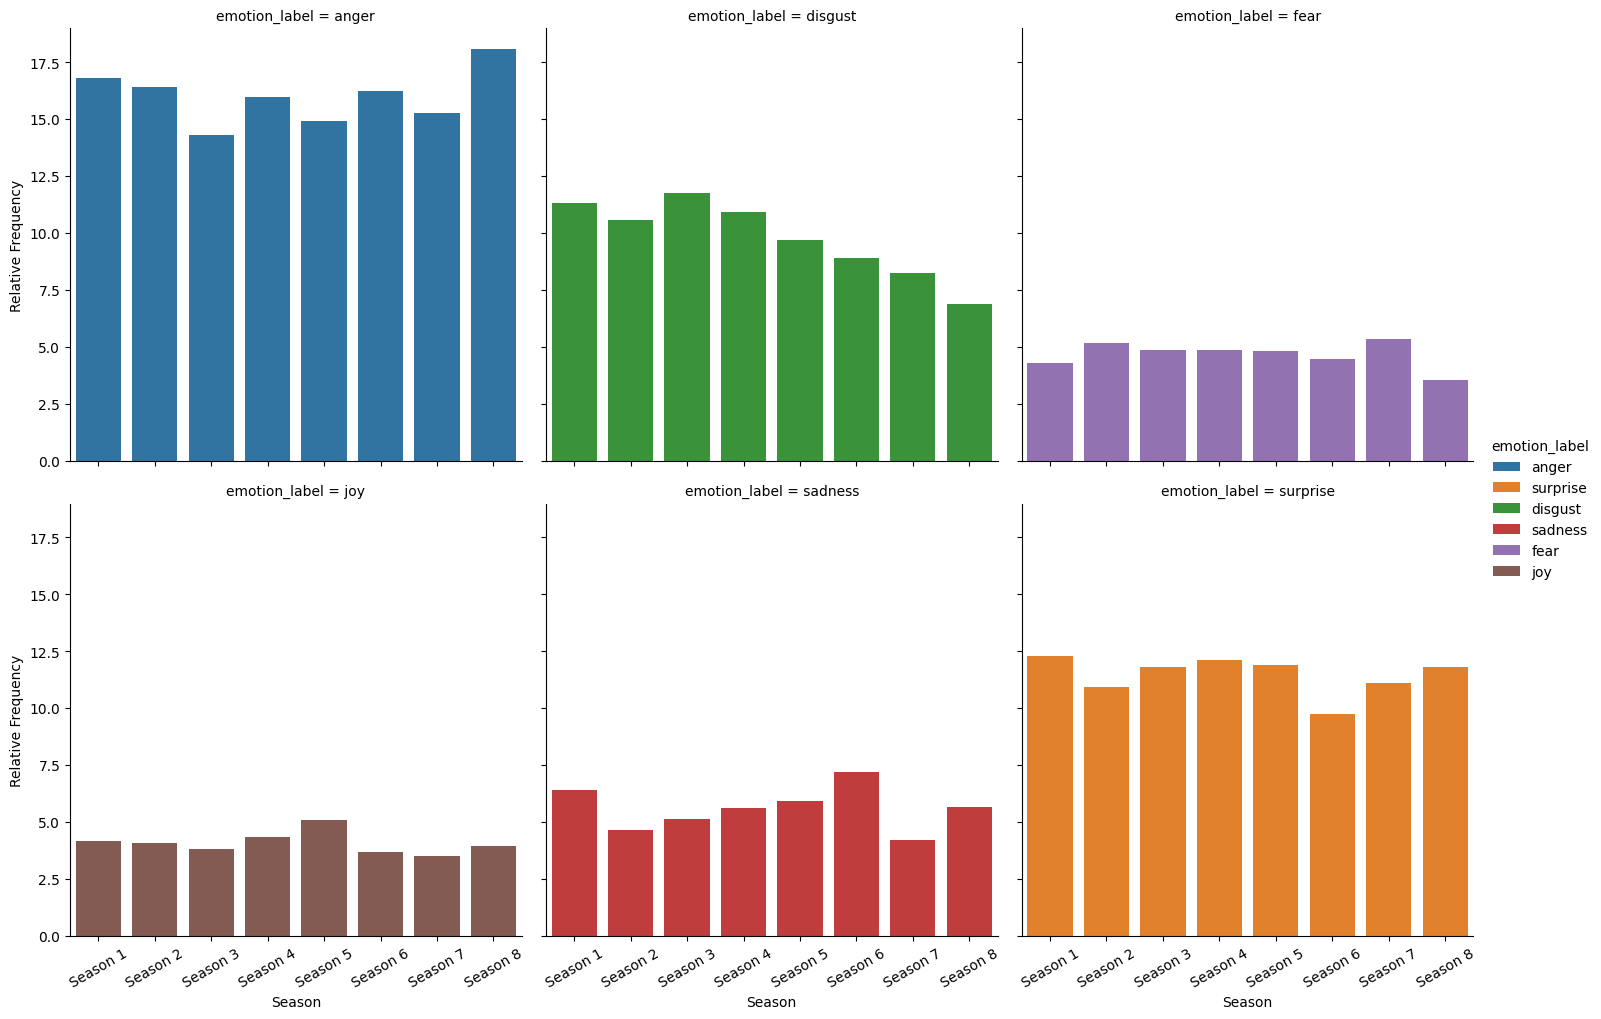

In [12]:
plot_emotions(data_counts, "remove_neutral")

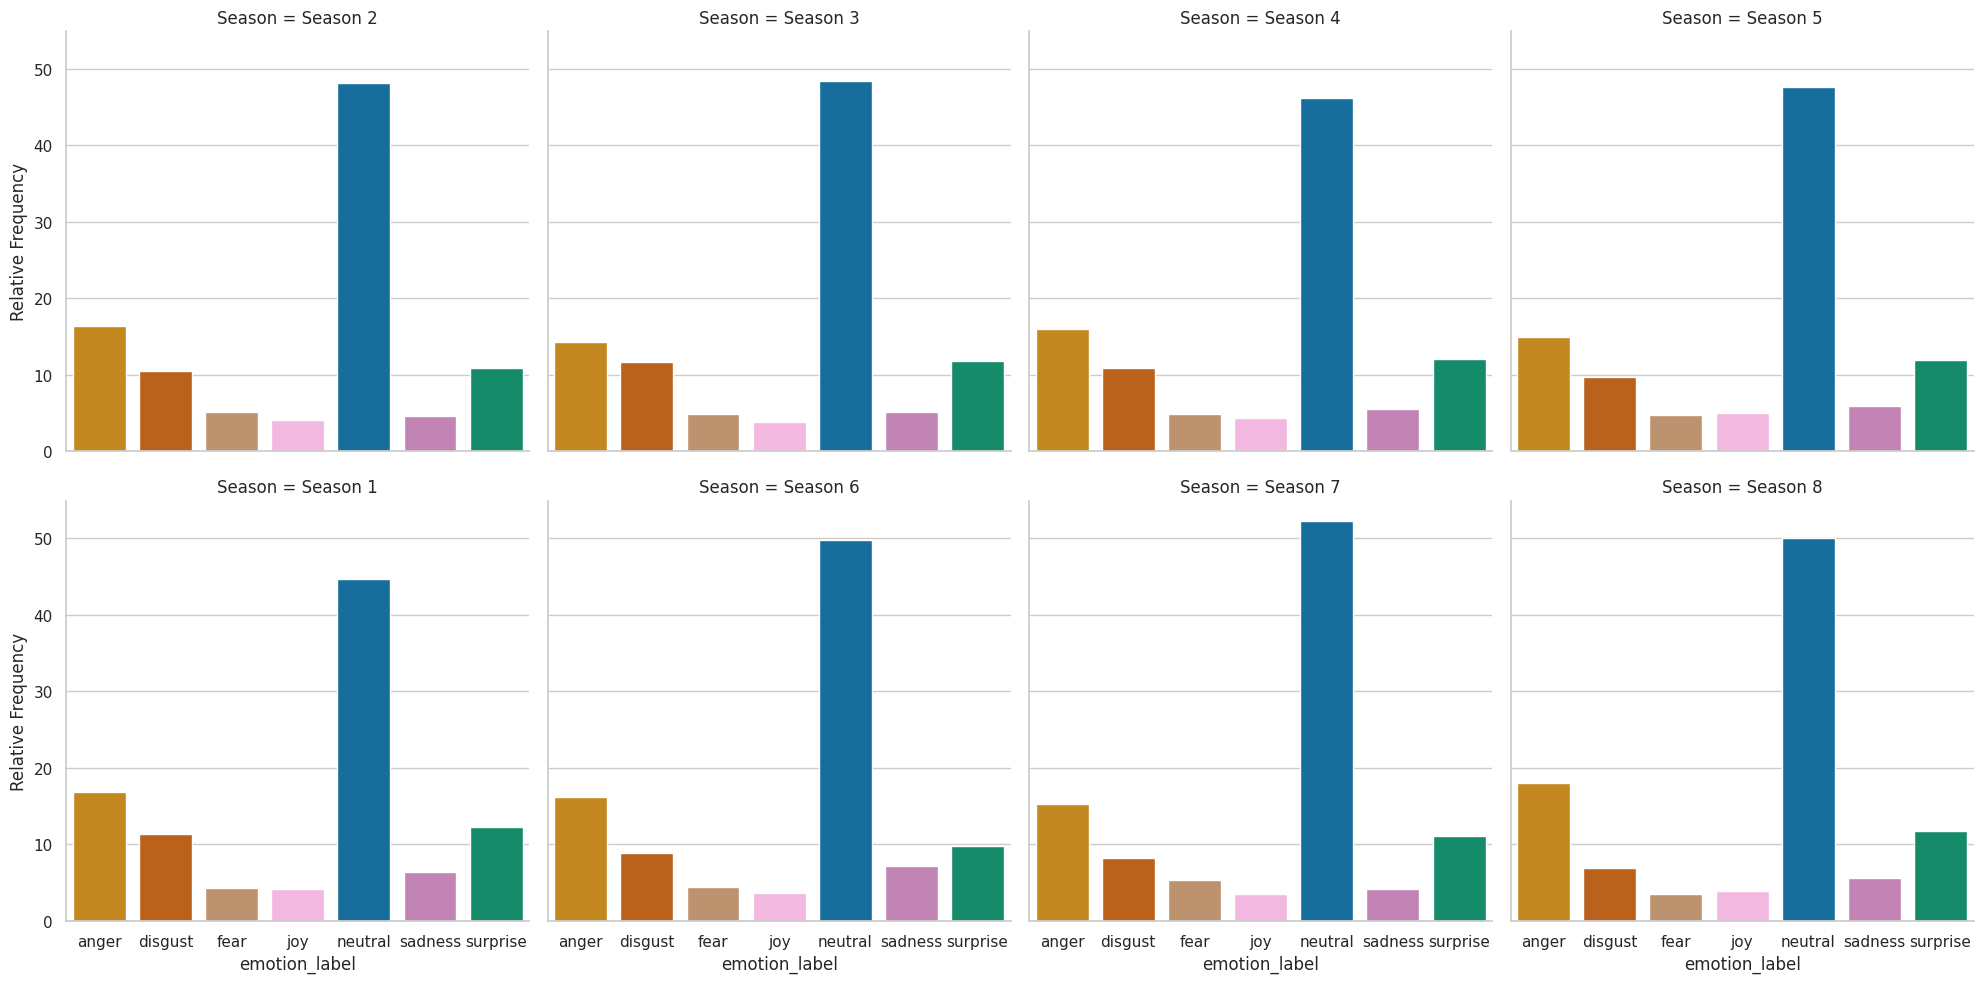

In [30]:
sns.set_theme(style = "whitegrid", palette="colorblind")
sns.catplot(data_counts, 
            x= "emotion_label", 
            y = "Relative Frequency",
            hue = "emotion_label",  
            col = "Season", 
            kind = "bar",
            col_wrap = 4,
            col_order = ["Season 1", "Season 2", "Season 3", "Season 4", "Season 5", "Season 6", "Season 7", "Season 8"]
            fill = True, 
            order = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
             )

In [ ]:
def season_plot(data_emotions_path):
    data_emotions = pd.read_csv(data_emotions_path)
    g = sns.FacetGrid(data_emotions, col="Season", hue = "emotion_label")
    g.map(sns.catplot, data_emotions, x = "emotion_label", 
                                      kind = "count", 
                                      pallette = "pastel")

In [44]:
data_emotions_plot = pd.DataFrame(columns=["emotion_label", "Season", "n_lines", "rel_freq"])

In [55]:
data_emotions_plot = data_emotions.loc[:, ["Season", "emotion_label"]]

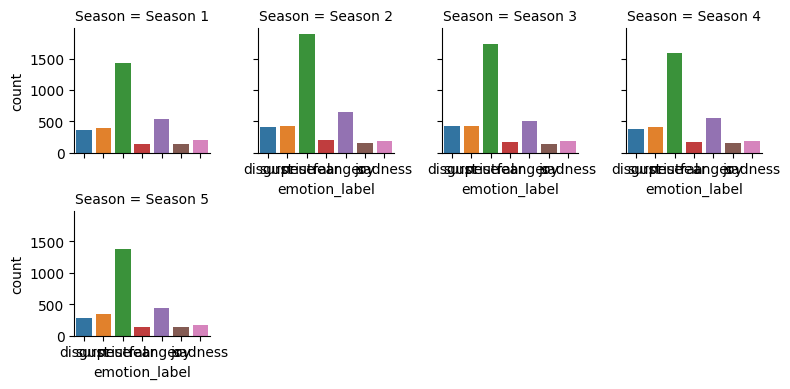

In [41]:
sns.catplot(data_emotions.loc[0:17000], 
                x= "emotion_label", 
                hue = "emotion_label", 
                kind = "count", 
                col = "Season", 
                col_wrap = 4, 
                height = 2)
#g.set_axis_labels("", "count")


In [11]:
def load_data(filepath):
    data_emotions_path = (filepath).split("/")[-1].split(".")[0] + "_with_emotion_scores.csv"
    data_in = pd.read_csv(filepath)
    data_emotions = pd.read_csv(filepath)
    data_emotions[["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]] = ""
    return data_in, data_emotions, data_emotions_path

In [6]:
def emotion_classifier(data_in, data_emotions, classifier, data_emotions_path):
    for sent in range(len(data_in["Sentence"])):
        sentence = data_in["Sentence"][sent]
        if type(sentence) == str:
            emotion_dicts = classifier(sentence)[0]
            emotion_scores = []
            for dict in emotion_dicts:
                score = dict["score"]
                emotion_scores = emotion_scores + [score]
            data_emotions.loc[sent, "anger":"surprise"] = emotion_scores
    data_emotions.to_csv(emotions_path)
    return print("Emotion scores for each sentence in the dataset have been saved to the outfolder")

In [7]:
classifier = load_classifier()
data_in, data_out = load_data("../in/GoT-scripts/Game_of_Thrones_Script.csv")
data_out = emotion_classifier(data_in, classifier, data_out, "../out/emotion_scores.csv")

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
/home/ucloud/.local/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [28]:
#read in saved df 
data_emotions = pd.read_csv("../out/emotion_scores.csv", index_col=0)
#make long format to use in plots
data_emot_long = pd.melt(data_emotions, id_vars=(['Sentence', 'Season', 'Episode']), value_vars=["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"])

In [ ]:
#inspect data
data_emot_long["variable"].value_counts()
data_emotions.describe(include="all")

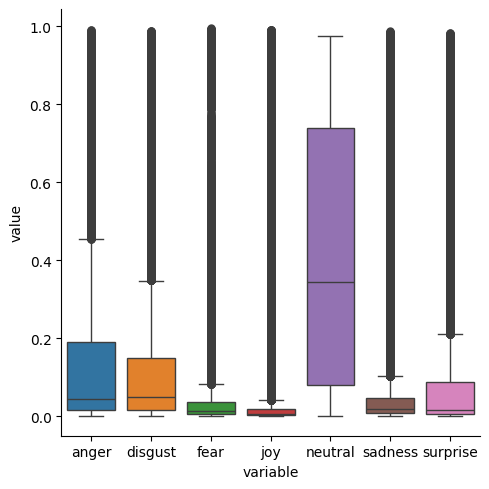

In [38]:
#boxplot
sns.catplot(data_emot_long, x="variable", y="value", kind="box", hue = "variable")
#plt.savefig("../out/boxplot_wo_neutral.png")


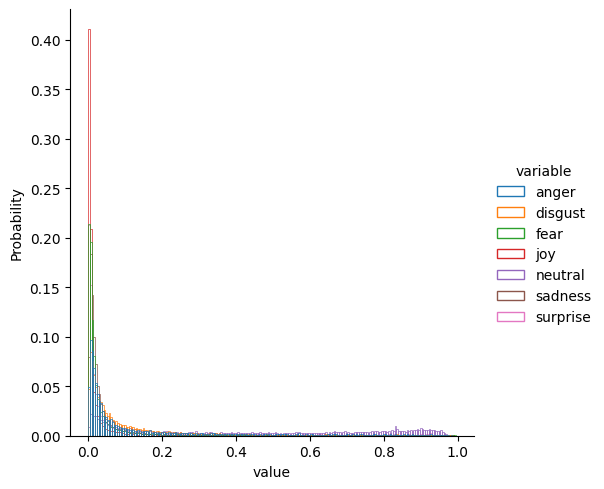

In [37]:
#sns.displot(data_emot_long, x="value", col = "Season", hue = "variable", kde=True, stat="density", common_norm=False)
sns.displot(data_emot_long, x="value",hue = "variable", kde=False, stat="probability", fill = False, common_norm = False)

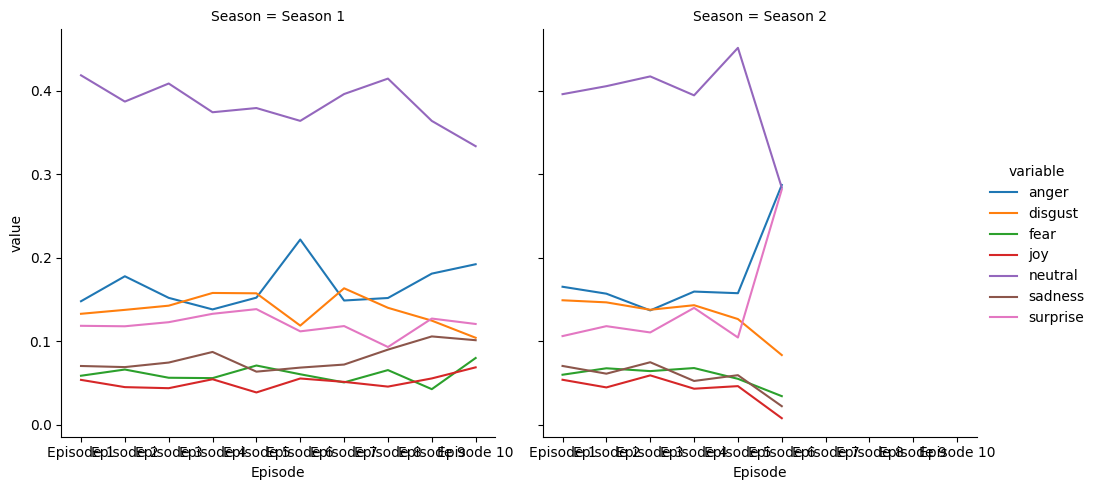

In [66]:
#sns.displot(data_long, x="value", col = "Season", hue = "variable", kde=True)
#sns.displot(data_long, x="value", col = "Season", hue = "variable", kind = "kde", bw_adjust = .2)
#sns.displot(data_long, x="value", hue="variable", col = "Season", multiple="stack")
#sns.catplot(data_long, x="variable", y="value", kind="box", col = "Season")
#sns.catplot(data_long, x="variable", y="value", kind="boxen", col = "Season", hue = "variable")

sns.relplot(x="Episode", y="value", hue="variable", kind = "line", errorbar = None, col = "Season", data=data_long)